In [113]:
#import libraries
import pandas as pd
import random #use to generate data
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [51]:
# --- Constants and Configuration ---
CROP_VALUES = {
    'Soja': 3000, 'Milho': 2500, 'Arroz': 2000,
    'Feijão': 3500, 'Trigo': 1800, 'Aveia': 1500
}
JUNE_CROPS = [1,2,3,4] # 1 = 'Soja', 2 = 'Milho', 3 = 'Arroz', 4 = 'Feijão'
JANUARY_CROPS = [5,6] # 5 = 'Trigo', 6 = 'Aveia'
ALL_CROPS = JUNE_CROPS + JANUARY_CROPS
LOAN_TERMS = [180, 360] # Updated loan terms as per new requirements
MAX_LOANS_PER_YEAR = 3
MIN_LOAN_INTERVAL_DAYS = 30 # Minimum days between loans for the same client

# Hectar Constants
MIN_TOTAL_HECTAR_CLIENT = 50  # Minimum total hectares a client might own
MAX_TOTAL_HECTAR_CLIENT = 1000 # Maximum total hectares a client might own
# Percentage of client's total_hectares_client that can be taken for a SINGLE loan
MIN_LOAN_HECTAR_PORTION = 0.05
MAX_LOAN_HECTAR_PORTION = 0.50

# Maximum attempts to find an eligible client for a new loan in historic generation
MAX_ATTEMPTS_TO_FIND_CLIENT = 1000

In [52]:
# --- Helper Functions ---

def _calculate_loan_amount(hectar, culture):
    """Calculates loan amount based on hectares and crop type."""
    return round(hectar * CROP_VALUES.get(culture, 0), 2)

In [53]:
def _determine_rating(score):
    """Determines credit rating based on FICO score."""
    if score >= 750:
        return 5  # AAA
    elif score >= 700:
        return 4  # AA
    elif score >= 600:
        return 3  # A
    elif score >= 500:
        return 2  # B
    elif score >= 400:
        return 1  # C
    else:
        return 0  # D (High Risk)

In [54]:
def _simulate_score_change(current_score, had_previous_default):
    """Simulates score change for the NEXT loan based on previous default status."""
    if had_previous_default:
        # Score drops more significantly after a default
        score_change = random.randint(-120, -10) # Can drop by up to 120 points
    else:
        # Normal fluctuation, slight chance of increase/decrease
        score_change = random.randint(-20, 40) # Can increase slightly more than decrease

    new_score = max(200, min(850, current_score + score_change))
    return new_score

In [55]:
def _simulate_payment_delay_days(score, had_previous_default):
    """
    Simulates the number of days payment is delayed (can be negative for early payment).
    Lower score and previous default increase chance of delay.
    """
    delay_prob = 0
    if score < 400:
        delay_prob = 0.85 # High chance of significant delay
    elif score < 500:
        delay_prob = 0.60 # Moderate chance
    elif score < 600:
        delay_prob = 0.30 # Low chance
    elif score < 700:
        delay_prob = 0.10 # Low chance
    else:
        delay_prob = 0.02 # Very low chance

    if had_previous_default:
        delay_prob = min(1.0, delay_prob * 1.5) # Increase delay probability if previous default

    if random.random() < delay_prob:
        # Client delays payment
        if score < 400:
            return random.randint(20, 120) # More significant delay for lowest scores
        elif score < 500:
            return random.randint(10, 60)
        elif score < 600:
            return random.randint(5, 30)
        else:
            return random.randint(1, 15) # Small delay for higher scores
    else:
        # Client pays on time or early
        return random.randint(-10, 3) # Up to 10 days early, or 3 days late (still considered on time for this logic)

In [56]:
# --- Main Data Generation Functions ---

def generate_first_transactions(num_unique_clients: int):
    """
    Generates the first transaction for a specified number of unique clients.
    Returns a list of dictionaries and a dictionary of client states.
    """
    first_transactions_data = []
    # client_states now tracks hectares_used per season and their due dates
    client_states = {} 

    for i in range(num_unique_clients):
        client_id = f"CLIENT_{i:04d}"
        initial_score = random.randint(200, 850)
        total_hectares_client = round(random.uniform(MIN_TOTAL_HECTAR_CLIENT, MAX_TOTAL_HECTAR_CLIENT), 2)

        # Randomize initial loan date over a few years, ensuring it aligns with a crop month
        start_year = 2020 + random.randint(0, 3)
        initial_month = random.choice([1, 6]) # January or June
        loan_date = datetime(start_year, initial_month, random.randint(1, 28))

        income = round(random.uniform(5000, 500000), 2)
        culture = random.choice(JUNE_CROPS if initial_month == 6 else JANUARY_CROPS)

        # Hectar for this loan is a portion of total_hectares_client
        hectar = round(random.uniform(total_hectares_client * MIN_LOAN_HECTAR_PORTION,
                                     total_hectares_client * MAX_LOAN_HECTAR_PORTION), 2)
        hectar = max(1.0, min(hectar, total_hectares_client)) # Ensure hectar is valid

        loan_amount = _calculate_loan_amount(hectar, culture)
        loan_amount_term = random.choice(LOAN_TERMS)
        loan_due_date = loan_date + timedelta(days=loan_amount_term)

        # Simulate payment delay/early payment
        payment_delay_days = _simulate_payment_delay_days(initial_score, False) # No previous default for first loan
        payment_date = loan_due_date + timedelta(days=payment_delay_days)

        # Determine default status based on payment date vs due date
        default_status = 1 if payment_date > loan_due_date else 0

        rating = _determine_rating(initial_score)
        total_debt = round(random.uniform(loan_amount, min(loan_amount * 2, income * 3)), 2)
        # Explicitly ensure total_debt is not less than loan_amount (already handled by uniform, but reinforces rule)
        total_debt = max(total_debt, loan_amount)

        first_transactions_data.append({
            'id_client': client_id,
            'loan_date': loan_date.strftime('%Y-%m-%d'),
            'loan_due_date': loan_due_date.strftime('%Y-%m-%d'),
            'payment_date': payment_date.strftime('%Y-%m-%d'),
            'income': income,
            'culture': culture,
            'hectar': hectar,
            'total_hectares_client': total_hectares_client,
            'loan_amount': loan_amount,
            'loan_amount_term': loan_amount_term,
            'rating': rating,
            'score': initial_score,
            'total_debt': total_debt,
            'default_status': default_status,
            'transaction_type': 'first'
        })

        # Initialize client state for tracking hectares used per season
        client_states[client_id] = {
            'score': initial_score,
            'last_default_status': bool(default_status),
            'last_loan_date': loan_date,
            'loans_this_year': {loan_date.year: 1},
            'total_hectares_client': total_hectares_client,
            'hectares_used_june_season': hectar if culture in JUNE_CROPS else 0,
            'june_loan_due_date': loan_due_date if culture in JUNE_CROPS else None,
            'hectares_used_january_season': hectar if culture in JANUARY_CROPS else 0,
            'january_loan_due_date': loan_due_date if culture in JANUARY_CROPS else None,
        }
    return first_transactions_data, client_states

In [57]:
def generate_historic_transactions(
    first_transactions_data: list,
    client_states: dict,
    num_total_rows: int
):
    """
    Generates additional historic transactions, applying all new rules.
    """
    all_transactions_data = list(first_transactions_data)
    eligible_clients = list(client_states.keys())
    transactions_generated = len(first_transactions_data)
    
    attempts = 0 # To prevent infinite loops if clients run out of options

    while transactions_generated < num_total_rows and attempts < MAX_ATTEMPTS_TO_FIND_CLIENT * (num_total_rows - transactions_generated):
        client_id = random.choice(eligible_clients)
        client_state = client_states[client_id]
        
        # Advance loan_date realistically, ensuring it's after the last loan and in a valid month
        # Start a new transaction 1 month to 1 year after the last loan, plus random days
        base_future_date = client_state['last_loan_date'] + timedelta(days=random.randint(MIN_LOAN_INTERVAL_DAYS, 365))
        
        # Determine the month for the next loan (June or January)
        next_loan_month = random.choice([1, 6])
        
        # Set the loan_date to the determined month in the base_future_date's year
        loan_date = datetime(base_future_date.year, next_loan_month, random.randint(1, 28))

        # Ensure loan_date is always after the last loan for the same client
        if loan_date <= client_state['last_loan_date']:
            # If generated date is not sufficiently after last loan, push it forward
            loan_date = client_state['last_loan_date'] + timedelta(days=MIN_LOAN_INTERVAL_DAYS)
            # Re-adjust month if it changed and needs to be January/June
            if loan_date.month not in [1, 6]:
                loan_date = datetime(loan_date.year, next_loan_month, random.randint(1, 28))
                if loan_date <= client_state['last_loan_date']: # Ensure it's still after if year changed
                    loan_date = datetime(loan_date.year + 1, next_loan_month, random.randint(1, 28))

        # --- Free up hectares from matured loans ---
        if client_state['june_loan_due_date'] and loan_date > client_state['june_loan_due_date']:
            client_state['hectares_used_june_season'] = 0
            client_state['june_loan_due_date'] = None
        if client_state['january_loan_due_date'] and loan_date > client_state['january_loan_due_date']:
            client_state['hectares_used_january_season'] = 0
            client_state['january_loan_due_date'] = None

        # --- Check loan limits for the year ---
        current_year = loan_date.year
        client_state['loans_this_year'].setdefault(current_year, 0) # Ensure year is in dict

        if client_state['loans_this_year'][current_year] >= MAX_LOANS_PER_YEAR:
            attempts += 1
            continue # Try next client/iteration

        # --- Determine available hectares for new loan based on season ---
        culture = random.choice(JUNE_CROPS if loan_date.month == 6 else JANUARY_CROPS)
        is_june_season_loan = culture in JUNE_CROPS
        
        if is_june_season_loan:
            available_hectares_for_this_loan = client_state['total_hectares_client'] - client_state['hectares_used_june_season']
            # If there's an active loan for the same season, ensure it's truly free
            if client_state['hectares_used_june_season'] > 0 and client_state['june_loan_due_date'] and loan_date <= client_state['june_loan_due_date']:
                # Loan for this season is still active, cannot take another one for the same season
                attempts += 1
                continue
        else: # January season loan
            available_hectares_for_this_loan = client_state['total_hectares_client'] - client_state['hectares_used_january_season']
            # If there's an active loan for the same season, ensure it's truly free
            if client_state['hectares_used_january_season'] > 0 and client_state['january_loan_due_date'] and loan_date <= client_state['january_loan_due_date']:
                # Loan for this season is still active, cannot take another one for the same season
                attempts += 1
                continue
        
        if available_hectares_for_this_loan < 1.0: # Need at least 1 hectare to make a loan
            attempts += 1
            continue

        # --- Determine hectar for the new loan ---
        hectar = round(random.uniform(available_hectares_for_this_loan * MIN_LOAN_HECTAR_PORTION,
                                     available_hectares_for_this_loan * MAX_LOAN_HECTAR_PORTION), 2)
        hectar = max(1.0, min(hectar, available_hectares_for_this_loan)) # Ensure valid range

        if hectar < 1.0: # Minimum hectare for a loan
            attempts += 1
            continue

        # --- Generate other transaction details ---
        current_score_for_this_loan = _simulate_score_change(client_state['score'], client_state['last_default_status'])
        client_state['score'] = current_score_for_this_loan # Update client's score for future transactions

        income = round(random.uniform(5000, 500000), 2)
        loan_amount = _calculate_loan_amount(hectar, culture)
        loan_amount_term = random.choice(LOAN_TERMS)
        loan_due_date = loan_date + timedelta(days=loan_amount_term)

        payment_delay_days = _simulate_payment_delay_days(current_score_for_this_loan, client_state['last_default_status'])
        payment_date = loan_due_date + timedelta(days=payment_delay_days)

        default_status = 1 if payment_date > loan_due_date else 0
        rating = _determine_rating(current_score_for_this_loan)
        total_debt = round(random.uniform(loan_amount, min(loan_amount * 2, income * 3)), 2)
        total_debt = max(total_debt, loan_amount) # Ensure total_debt is not less than loan_amount

        # --- Update client state after successful loan generation ---
        client_state['last_default_status'] = bool(default_status)
        client_state['last_loan_date'] = loan_date
        client_state['loans_this_year'][current_year] += 1

        if is_june_season_loan:
            client_state['hectares_used_june_season'] = hectar
            client_state['june_loan_due_date'] = loan_due_date
        else:
            client_state['hectares_used_january_season'] = hectar
            client_state['january_loan_due_date'] = loan_due_date

        all_transactions_data.append({
            'id_client': client_id,
            'loan_date': loan_date.strftime('%Y-%m-%d'),
            'loan_due_date': loan_due_date.strftime('%Y-%m-%d'),
            'payment_date': payment_date.strftime('%Y-%m-%d'),
            'income': income,
            'culture': culture,
            'hectar': hectar,
            'total_hectares_client': client_state['total_hectares_client'],
            'loan_amount': loan_amount,
            'loan_amount_term': loan_amount_term,
            'rating': rating,
            'score': current_score_for_this_loan,
            'total_debt': total_debt,
            'default_status': default_status,
            'transaction_type': 'historic'
        })
        transactions_generated += 1
        attempts = 0 # Reset attempts after a successful transaction

    if transactions_generated < num_total_rows:
        print(f"Warning: Could only generate {transactions_generated} rows out of {num_total_rows} due to client eligibility constraints and max attempts.")

    return all_transactions_data


In [58]:
# --- Execution ---

def main(num_total_rows: int = 20000, num_unique_clients: int = 1000):
    """
    Main function to orchestrate data generation and return DataFrames.
    """
    print(f"Generating {num_unique_clients} first transactions...")
    first_transactions_list, client_states = generate_first_transactions(num_unique_clients)
    df_first_transactions = pd.DataFrame(first_transactions_list)

    print(f"Generating {num_total_rows - num_unique_clients} historic transactions...")
    all_transactions_list = generate_historic_transactions(
        first_transactions_list,
        client_states,
        num_total_rows
    )
    df_historic_transactions = pd.DataFrame(all_transactions_list)

    # Convert date columns to datetime objects for proper sorting and analysis
    df_historic_transactions['loan_date'] = pd.to_datetime(df_historic_transactions['loan_date'])
    df_historic_transactions['loan_due_date'] = pd.to_datetime(df_historic_transactions['loan_due_date'])
    df_historic_transactions['payment_date'] = pd.to_datetime(df_historic_transactions['payment_date'])
    
    # Sort historic transactions by client and date to ensure chronological order
    df_historic_transactions = df_historic_transactions.sort_values(by=['id_client', 'loan_date']).reset_index(drop=True)

    print("\nData generation complete!")
    print(f"First transactions DataFrame has '{len(df_first_transactions)}' rows.")
    print(f"Historic transactions DataFrame has '{len(df_historic_transactions)}' rows.")


    return df_first_transactions, df_historic_transactions

In [59]:
# Generate 20,000 rows
# You can adjust the total number of rows and unique clients here
df_first, df_historic = main(num_total_rows=20000, num_unique_clients=8000)


Generating 8000 first transactions...
Generating 12000 historic transactions...

Data generation complete!
First transactions DataFrame has '8000' rows.
Historic transactions DataFrame has '20000' rows.


In [60]:
# df_credit.describe()
# df_credit.head()
df_historic.head()

,id_client,loan_date,loan_due_date,payment_date,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status,transaction_type
0,CLIENT_0000,2022-06-20,2023-06-15,2023-09-27,205340.45,3,178.06,430.40,0.0,360,0,247,0.0,1,first
1,CLIENT_0000,2023-01-16,2024-01-11,2024-04-24,340895.12,6,165.62,430.40,0.0,360,0,232,0.0,1,historic
2,CLIENT_0000,2024-01-13,2025-01-07,2025-04-10,438000.32,6,168.13,430.40,0.0,360,0,200,0.0,1,historic
3,CLIENT_0000,2024-06-26,2024-12-23,2025-03-10,296662.19,1,123.96,430.40,0.0,180,0,200,0.0,1,historic
4,CLIENT_0001,2021-06-05,2022-05-31,2022-05-31,99323.52,1,295.38,646.67,0.0,360,4,714,0.0,0,first


In [29]:
df_historic.to_excel('historic.xlsx', index=False, sheet_name='Sheet1')

In [61]:
# Filter clients who have ever defaulted (default_status == 1)
clients_with_default = df_historic[df_historic['default_status'] == 1]['id_client'].unique()
df_historic[df_historic['id_client'].isin(clients_with_default)]

,id_client,loan_date,loan_due_date,payment_date,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status,transaction_type
0,CLIENT_0000,2022-06-20,2023-06-15,2023-09-27,205340.45,3,178.06,430.40,0.0,360,0,247,0.0,1,first
1,CLIENT_0000,2023-01-16,2024-01-11,2024-04-24,340895.12,6,165.62,430.40,0.0,360,0,232,0.0,1,historic
2,CLIENT_0000,2024-01-13,2025-01-07,2025-04-10,438000.32,6,168.13,430.40,0.0,360,0,200,0.0,1,historic
3,CLIENT_0000,2024-06-26,2024-12-23,2025-03-10,296662.19,1,123.96,430.40,0.0,180,0,200,0.0,1,historic
5,CLIENT_0002,2022-01-25,2022-07-24,2022-09-18,195900.05,5,173.05,838.44,0.0,180,0,343,0.0,1,first
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19993,CLIENT_7996,2023-01-02,2023-12-28,2023-12-24,275714.29,5,124.35,496.42,0.0,360,5,795,0.0,0,historic
19996,CLIENT_7998,2022-06-25,2023-06-20,2023-06-12,40648.28,1,21.34,418.44,0.0,360,2,598,0.0,0,first
19997,CLIENT_7998,2023-01-02,2023-07-01,2023-07-02,260251.43,6,25.66,418.44,0.0,180,3,630,0.0,1,historic
19998,CLIENT_7999,2022-06-09,2022-12-06,2022-12-04,195976.42,4,202.13,536.45,0.0,180,1,498,0.0,0,first


In [ ]:

# clear dataset to remove null data
df_credit_clear = df_historic.dropna()
df_credit_clear = df_credit_clear.drop(columns=['transaction_type','loan_date', 'loan_due_date', 'payment_date'])
df_credit_clear.count()

id_client                20000
loan_date                20000
loan_due_date            20000
payment_date             20000
income                   20000
culture                  20000
hectar                   20000
total_hectares_client    20000
loan_amount              20000
loan_amount_term         20000
rating                   20000
score                    20000
total_debt               20000
default_status           20000
transaction_type         20000
dtype: int64

In [ ]:
# transform id_client to int
df_credit_clear['id_client'] = df_credit_clear['id_client'].str.replace('CLIENT_', '').astype(int)

In [136]:
# df_credit_clear.sort_values(by="rating", ascending=True).head()
df_credit_clear.describe()
# df_credit_clear.columns

,income,culture,hectar,total_hectares_client,loan_amount,loan_amount_term,rating,score,total_debt,default_status
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.0,20000.000000,20000.000000,20000.000000,20000.0,20000.00000
mean,252234.513311,3.917400,145.345371,526.951096,0.0,270.684000,1.843900,496.641250,0.0,0.61975
std,142301.770456,1.740353,108.313089,274.689760,0.0,89.999651,1.825212,204.686571,0.0,0.48546
min,5004.960000,1.000000,3.100000,50.070000,0.0,180.000000,0.000000,200.000000,0.0,0.00000
25%,128996.540000,2.000000,57.060000,288.430000,0.0,180.000000,0.000000,308.000000,0.0,0.00000
50%,252968.980000,4.000000,116.595000,528.730000,0.0,360.000000,1.000000,495.000000,0.0,1.00000
75%,374628.815000,5.000000,212.322500,764.760000,0.0,360.000000,3.000000,679.000000,0.0,1.00000
max,499956.780000,6.000000,497.200000,999.890000,0.0,360.000000,5.000000,850.000000,0.0,1.00000


In [122]:
#Split dataset into features and target variable
dt_x = df_credit_clear.iloc[:, :-1]
dt_y = df_credit_clear.iloc[:, -1]

In [123]:
#Split the dataset into temporary and testing sets
dt_x_temp, dt_x_test, dt_y_temp, dt_y_test = train_test_split(dt_x, dt_y, test_size=0.2)

In [127]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('reducer', PCA()),
    ('classifier', RandomForestClassifier())])

pc = pipe.fit(dt_x_temp, dt_y_temp)

pc

,steps,"[('scaler', ...), ('reducer', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'


In [128]:
y_pred = pipe.predict(dt_x_test)
accuracy_score(dt_y_test, y_pred)

0.79725

Testes com o random search

In [129]:
max_depths_list = np.arange(1,101) # Odd numbers from 1 to 100

masx_features = np.linspace(0.001, 0.5, 100)

parameter_grid = {
    'max_depth': max_depths_list,
    'max_features': masx_features}

number_iterations = 10

grid = RandomizedSearchCV(estimator=RandomForestClassifier(),
                         param_distributions=parameter_grid,
                         scoring='accuracy',
                         n_iter=number_iterations,
                         return_train_score=True)

grid.fit(dt_x_temp, dt_y_temp)

,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': array([ 1, ...98, 99, 100]), 'max_features': array([0.001 ..., 0.5 ])}"
,n_iter,10
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


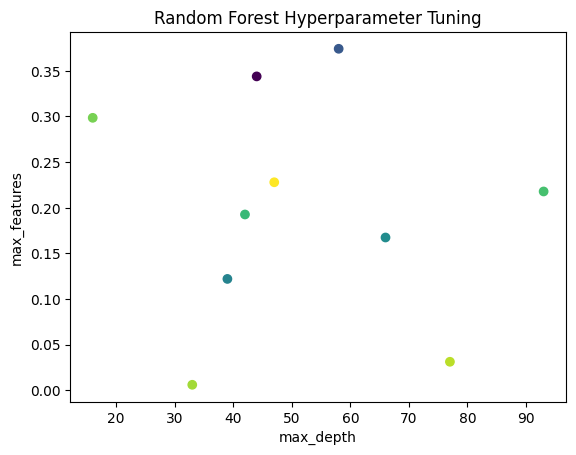

In [130]:
tested_x = list(grid.cv_results_['param_max_depth'])
tested_y = list(grid.cv_results_['param_max_features'])

plt.scatter(tested_x, tested_y, c=grid.cv_results_['mean_test_score'], cmap='viridis')
plt.gca().set(xlabel='max_depth', ylabel='max_features', title='Random Forest Hyperparameter Tuning')
plt.show()

In [87]:
grid.best_index_

np.int64(0)

In [88]:
grid.best_params_

{'max_features': np.float64(0.001), 'max_depth': np.int64(6)}

In [89]:
grid.best_score_

np.float64(0.796125)

In [90]:
predictions = grid.predict(dt_x_test)
print(accuracy_score(dt_y_test, predictions))

0.79575


Test to validate models

In [105]:
#example to test hiperparameters on Random Forest
max_depths_list = [5,10]

In [106]:
hyperparameter_avg_metric = []
metric_log = []

In [107]:
for max_depth in max_depths_list:
    print(f"Testing max_depth: {max_depth}")
    # Create a Random Forest model with the current max_depth
    rf_model = RandomForestClassifier(max_depth=max_depth)
    
    model_metrics = []

    # Perform cross-validation
    kf = KFold(n_splits=10, shuffle=True)
    splits = kf.split(dt_x_temp)
    
    for train_index, validate_index in splits:
        X_train, X_validate = dt_x_temp.iloc[train_index], dt_x_temp.iloc[validate_index]
        y_train, y_validate = dt_y_temp.iloc[train_index], dt_y_temp.iloc[validate_index]

        # Fit the model
        rf_model.fit(X_train, y_train)

        # Predict on the validation set
        predictions = rf_model.predict(X_validate)

        # Calculate accuracy
        model_metrics.append( accuracy_score(y_validate, predictions))
        metric_log.append(accuracy_score(y_validate, predictions))

    hyperparameter_avg_metric.append(np.mean(model_metrics))

Testing max_depth: 5
Testing max_depth: 10


In [108]:
metric_log

[0.800625,
 0.7875,
 0.779375,
 0.804375,
 0.798125,
 0.805625,
 0.78875,
 0.80875,
 0.7825,
 0.78375,
 0.786875,
 0.7875,
 0.8,
 0.786875,
 0.793125,
 0.795,
 0.80875,
 0.8,
 0.8,
 0.77125]

In [109]:
hyperparameter_avg_metric

[np.float64(0.7939375), np.float64(0.7929375000000001)]

In [104]:
model = RandomForestClassifier()

cv_results = cross_val_score(model, dt_x_temp, dt_y_temp, cv=10, scoring='accuracy')
cv_results

array([0.7875  , 0.795   , 0.79875 , 0.78375 , 0.779375, 0.770625,
       0.7875  , 0.77375 , 0.795   , 0.786875])